# Automated ML for time series predicion

We used one of the dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, i.e. NYC taxi passengers dataset, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot. 

In [1]:
%load_ext autoreload
%autoreload 2

## 0. Helper function definations

In [2]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    # target column of dataframe is "value"
    # past sequence length is 50
    pred_value = pred_df[value_col].values
    true_value = test_df[value_col].values[past_seq_len:]
    fig, axs = plt.subplots(figsize=(12, 5))

    axs.plot(pred_df[dt_col], pred_value, color='red', label='predicted values')
    axs.plot(test_df[dt_col][past_seq_len:], true_value, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
# plot results of multi step forecasting
# plot at most five values for better view
# plot the predicted values and actual values (for the test data)
def plot_less_five_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(min(pred_df.shape[1] - 1, 5))]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
    plot_color = ["g", "r", "c", "m", "y"]
    for i in range(len(value_cols)):
        pred_value = pred_df[value_cols[i]].values
        pred_dt = pred_df[dt_col].values + time_delta * i
        axs.plot(pred_dt, pred_value, color=plot_color[i], label='predicted values' + str(i))

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [4]:
# plot results of multi step forecasting
# plot result of multi step forecasting
# plot the predicted values and actual values (for the test data)
def plot_first_last_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(pred_df.shape[1] - 1)]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
  
    pred_value_first = pred_df[value_cols[0]].values
    pred_dt_first = pred_df[dt_col].values
    axs.plot(pred_dt_first, pred_value_first, color="g", label='first predicted values')
 
    pred_value_last = pred_df[value_cols[-1]].values
    pred_dt_last = pred_df[dt_col].values + time_delta * (len(value_cols)-1)
    axs.plot(pred_dt_last, pred_value_last, color="r", label='last predicted values')

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

## 1. load data

In [5]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import matplotlib.dates as md
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


Now we download the dataset and load it into a pandas dataframe.
Run the script `$ANALYTICS_ZOO_HOME/dist/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh` to download the raw data

In [6]:
# load nyc taxi data
try:
    dataset_path = os.getenv("ANALYTICS_ZOO_HOME")+"/bin/data/NAB/nyc_taxi/nyc_taxi.csv"
    raw_df = pd.read_csv(dataset_path)
except Exception as e:
    print("nyc_taxi.csv doesn't exist")
    print("you can run $ANALYTICS_ZOO_HOME/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh to download nyc_taxi.csv")

Below are some example records of the data

In [7]:
raw_df.head(5)

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Convert string timestamp to TimeStamp

In [8]:
df = pd.DataFrame(pd.to_datetime(raw_df.timestamp))
df["value"] = raw_df["value"]
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Change column name timestamp to datetime

In [9]:
df.set_index("timestamp", inplace=True)
df.index.name = "datetime"
df = df.reset_index()
df.head()

,datetime,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


You can use train_val_test_split to split the whole dataset into train/val/test sets. There will be two columns in the output dataframe: "datetime" and "value", where the data type of "datetime" column is datetime64.

In [10]:
from zoo.automl.common.util import train_val_test_split
train_df, val_df, test_df = train_val_test_split(df, val_ratio=0.1, test_ratio=0.1)

In [11]:
train_df.describe()

,value
count,8256.000000
mean,15421.585514
std,6871.989592
min,1431.000000
25%,11040.000000
50%,17014.500000
75%,20032.250000
max,39197.000000


In [12]:
train_df.head()

,datetime,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [13]:
# shape of the dataframe
print("The shape of train_df is", train_df.shape)
print("The shape of val_df is", val_df.shape)
print("The shape of test_df is", test_df.shape)

The shape of train_df is (8256, 2)
The shape of val_df is (1032, 2)
The shape of test_df is (1032, 2)


No handles with labels found to put in legend.


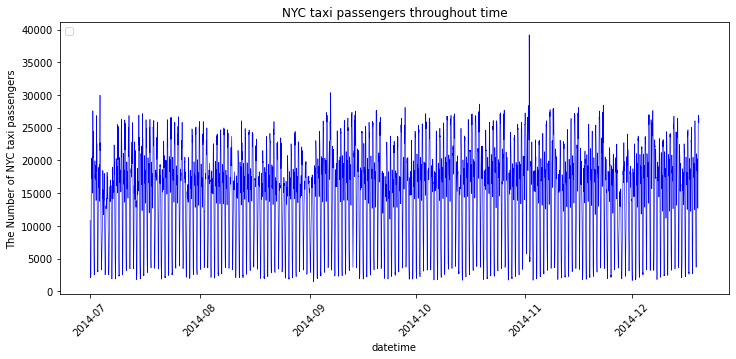

In [14]:
# visualisation of anomaly throughout time in train_df
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 5))
# pd.plotting.deregister_matplotlib_converters()

ax.plot(train_df['datetime'], train_df['value'], color='blue', linewidth=0.6)
ax.set_title('NYC taxi passengers throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('The Number of NYC taxi passengers')
plt.legend(loc='upper left')
plt.show()

## 2. Train and validation

You can use analytices zoo automl to predict time series data by simply define a `TimeSequencePredictor`. 

We use feature tools to generate features from the given datetime. The generated features are \['HOUR', 'DAY', 'MONTH'. 'IS_AWAKE', 'IS_BUSY_HOURS'\]. Our feature space comprises these generated features as well as the original inputs such as \['datetime','value','extra_features'\].  

Currently, We use RNN to learn from 50 previous values, and predict just the 1 next value. You can specify the sequence length to predict while creating `TimeSequencePredictor` with arg: `future_seq_len`.

In [15]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import *

# you need to specify the name of datetime column and target column
# The default names are "datetime" and "value" respectively.
tsp = TimeSequencePredictor(dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

In [16]:
from zoo import init_spark_on_local
from zoo.ray import RayContext
sc = init_spark_on_local(cores=4)
ray_ctx = RayContext(sc=sc, object_store_memory="1g")
ray_ctx.init()

Current pyspark location is : /Users/liuruolan/spark-2.4.3-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/__init__.py
Start to getOrCreate SparkContext


2020-06-04 10:42:49,688	INFO resource_spec.py:212 -- Starting Ray with 2.59 GiB memory available for workers and up to 0.93 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Successfully got a SparkContext


2020-06-04 10:42:50,102	INFO services.py:1148 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '172.20.10.2',
 'redis_address': '172.20.10.2:13848',
 'object_store_address': '/tmp/ray/session_2020-06-04_10-42-49_665217_4848/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-04_10-42-49_665217_4848/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-06-04_10-42-49_665217_4848'}

In [17]:
%%time
# fit train_df and validate with val_df, return the best trial as pipeline.
# the default recipe is SmokeRecipe,which runs one epoch and one iteration with only 1 random sample.
# you can change recipe by define `recipe` in `fit`. The recipes you can choose are SmokeRecipe, RandomRecipe, GridRandomRecipe and BayesRecipe.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mse",
                   recipe=RandomRecipe(look_back=(2, 4)))
print("Training completed.")

Trial name,status,loc,batch_size,dropout,dropout_1,dropout_2,latent_dim,lr,lstm_1_units,lstm_2_units,model,past_seq_len,selected_features,iter,total time (s)
train_func_00000,TERMINATED,,64,0.236066,0.262356,0.452359,128,0.00341797,128,32,LSTM,3,"[""WEEKDAY(datetime)"", ""IS_WEEKEND(datetime)"", ""HOUR(datetime)"", ""IS_BUSY_HOURS(datetime)""]",2,16.3351


best log dir is  /Users/liuruolan/ray_results/automl/train_func_0_batch_size=64,dropout=0.23607,dropout_1=0.26236,dropout_2=0.45236,latent_dim=128,lr=0.003418,lstm_1_units=128,lstm_2__2020-06-04_10-42-53y4yvav6i
The best configurations are:
selected_features : ["WEEKDAY(datetime)", "IS_WEEKEND(datetime)", "HOUR(datetime)", "IS_BUSY_HOURS(datetime)"]
model : LSTM
lstm_1_units : 128
dropout_1 : 0.2623564380566904
lstm_2_units : 32
dropout_2 : 0.4523587188264638
latent_dim : 128
dropout : 0.23606559098573093
lr : 0.003417968699730005
batch_size : 64
epochs : 5
past_seq_len : 3
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint argum

## 3. Test

In [18]:
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [19]:
pred_df.head(5)

,datetime,value
0,2015-01-10 13:30:00,22722.621094
1,2015-01-10 14:00:00,22034.908203
2,2015-01-10 14:30:00,20731.980469
3,2015-01-10 15:00:00,22342.509766
4,2015-01-10 15:30:00,23169.835938


In [20]:
# prediction value start from 50
test_df[50:55]

,datetime,value
50,2015-01-11 13:00:00,21296
51,2015-01-11 13:30:00,20381
52,2015-01-11 14:00:00,19508
53,2015-01-11 14:30:00,19210
54,2015-01-11 15:00:00,18255


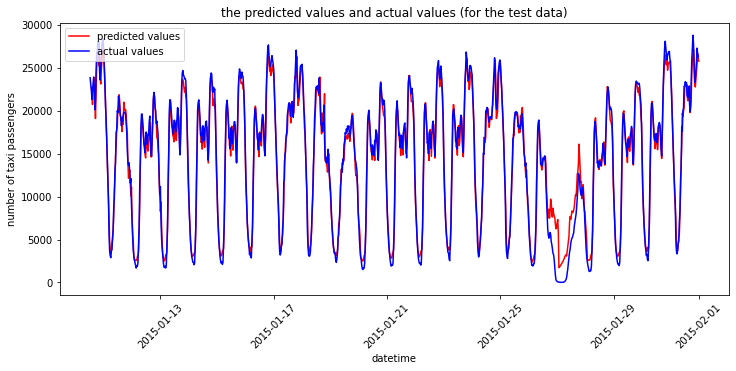

In [21]:
# plot the predicted values and actual values
plot_result(test_df, pred_df)

In [22]:
# evaluate test_df
mse, smape = pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 1613993.16756939
Evaluate: the smape value is 6.39230389742632


## 4. save and restore

We provide save and restore interface to save the pipeline with the best trial for easily rebuilding.

In [23]:
# save the pipeline with best trial
pipeline.save("/tmp/saved_pipeline/my.ppl")

Pipeline is saved in /tmp/saved_pipeline/my.ppl


'/tmp/saved_pipeline/my.ppl'

In [24]:
from zoo.automl.pipeline.time_sequence import load_ts_pipeline
new_pipeline = load_ts_pipeline("/tmp/saved_pipeline/my.ppl")

Restore pipeline from /tmp/saved_pipeline/my.ppl


In [25]:
# you can do predict and evaluate again
# we use test_df as input in order to compare results before and after restoration 
new_pred = new_pipeline.predict(test_df)

In [26]:
new_pred.head(5)

,datetime,value
0,2015-01-10 13:30:00,22722.621094
1,2015-01-10 14:00:00,22034.908203
2,2015-01-10 14:30:00,20731.980469
3,2015-01-10 15:00:00,22342.509766
4,2015-01-10 15:30:00,23169.835938


In [27]:
# evaluate test_df
mse, smape = new_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 1613993.16756939
Evaluate: the smape value is 6.39230389742632


## 5. continue training

We support continue training with incremental data using the best configuration searched and the trained model.

In [28]:
# review the initialization infomation if needed
new_pipeline.describe()

**** Initialization info ****
future_seq_len: 1
dt_col: datetime
target_col: value
extra_features_col: None
drop_missing: True



In [29]:
# Use val_df as incremental data
new_pipeline.fit(val_df,epoch_num=5)

Train on 1029 samples
Epoch 1/5
1029/1029 [==============================] - 1s 1ms/sample - loss: 0.0615 - mean_squared_error: 0.0615
Epoch 2/5
1029/1029 [==============================] - 0s 153us/sample - loss: 0.0556 - mean_squared_error: 0.0556
Epoch 3/5
1029/1029 [==============================] - 0s 144us/sample - loss: 0.0533 - mean_squared_error: 0.0533
Epoch 4/5
1029/1029 [==============================] - 0s 149us/sample - loss: 0.0572 - mean_squared_error: 0.0572
Epoch 5/5
1029/1029 [==============================] - 0s 160us/sample - loss: 0.0515 - mean_squared_error: 0.0515
Fit done!


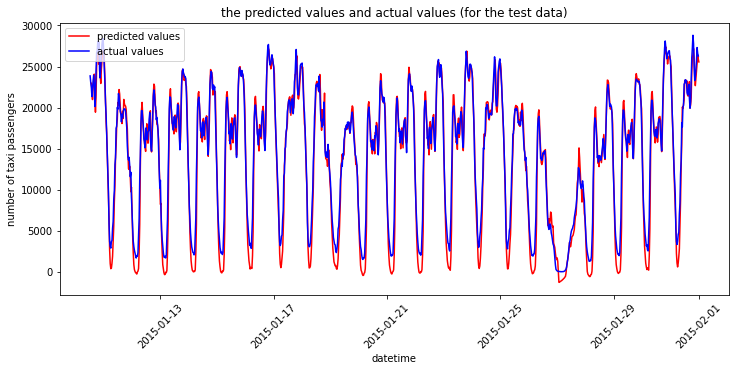

In [30]:
# predict results of test_df
new_pred_df = new_pipeline.predict(test_df)
plot_result(test_df, new_pred_df)

In [31]:
# evaluate test_df
mse, smape = new_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 2843081.9209067174
Evaluate: the smape value is 16.810818718628454


## 6. multi step forecasting 

You can do multi step forecasting by simply changing the `future_seq_len` option while creating a new `TimeSequencePredictor` object.

In [32]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import *

# change future_seq_len into the step you want to forcast.
tsp = TimeSequencePredictor(future_seq_len=5,
                            dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

In [33]:
%%time
# you can specify the look back sequence length with a single number or a range of (min_len, max_len) in RandomRecipe.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mse",
                   recipe=RandomRecipe(look_back=10))
print("Training completed.")

Trial name,status,loc,batch_size,dropout,dropout_1,dropout_2,latent_dim,lr,lstm_1_units,lstm_2_units,model,selected_features,iter,total time (s)
train_func_00000,TERMINATED,,32,0.415496,0.294753,0.40828,32,0.00815691,128,64,Seq2seq,"[""IS_WEEKEND(datetime)"", ""IS_AWAKE(datetime)"", ""IS_BUSY_HOURS(datetime)"", ""MONTH(datetime)"", ""WEEKDAY(datetime)""]",10,139.393


best log dir is  /Users/liuruolan/ray_results/automl/train_func_0_batch_size=32,dropout=0.4155,dropout_1=0.29475,dropout_2=0.40828,latent_dim=32,lr=0.0081569,lstm_1_units=128,lstm_2_u_2020-06-04_10-44-20wlwin0uh
The best configurations are:
selected_features : ["IS_WEEKEND(datetime)", "IS_AWAKE(datetime)", "IS_BUSY_HOURS(datetime)", "MONTH(datetime)", "WEEKDAY(datetime)"]
model : Seq2seq
lstm_1_units : 128
dropout_1 : 0.294753360932537
lstm_2_units : 64
dropout_2 : 0.40827952413443147
latent_dim : 32
dropout : 0.415495847442207
lr : 0.00815691287264193
batch_size : 32
epochs : 5
past_seq_len : 10
Training completed.
CPU times: user 6.52 s, sys: 1.23 s, total: 7.75 s
Wall time: 2min 29s


In [34]:
# test
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [35]:
pred_df.head(5)

,datetime,value_0,value_1,value_2,value_3,value_4
0,2015-01-10 17:00:00,17945.627082,16976.391579,16344.043558,15962.207792,15731.885464
1,2015-01-10 17:30:00,18610.449905,16929.892839,15919.130458,15393.478104,15196.022939
2,2015-01-10 18:00:00,20277.909700,17383.319918,15781.053218,15145.359663,15064.935653
3,2015-01-10 18:30:00,21390.143315,17869.144592,16023.694517,15360.252189,15390.984800
4,2015-01-10 19:00:00,21233.997145,17775.311981,16126.232394,15621.190245,15822.541543


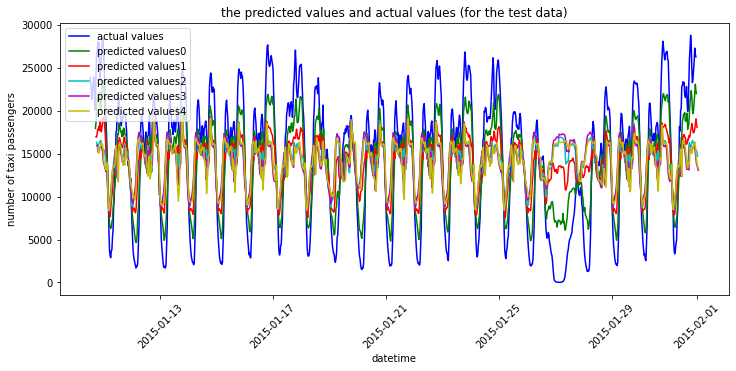

In [36]:
# plot multi step predicted values and actual values
# plot at most five step predict values for better view
plot_less_five_step_result(test_df, pred_df)

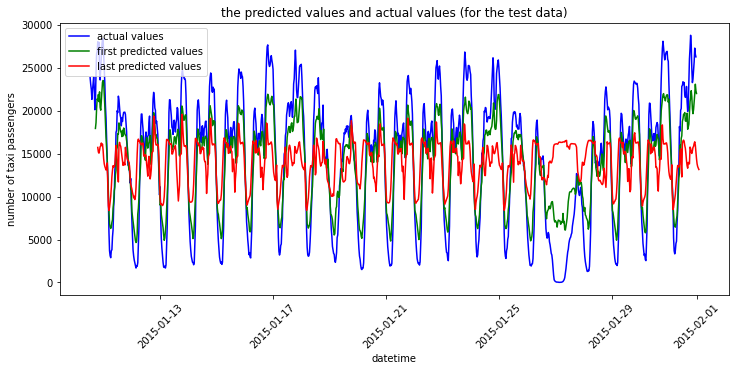

In [37]:
# plot only the first and the last step predict values and actual values
plot_first_last_step_result(test_df, pred_df)

In [38]:
# evaluate test_df
mse, smape = pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is [ 9216573.28996763 27430395.96174983 42012269.09612125 46813348.72105351
 44317901.35198148]
Evaluate: the smape value is [13.89246565 19.77553228 22.70994624 23.66121553 23.51672285]


In [39]:
ray_ctx.stop()